
# Análisis Dask
> Usamos `katalog_gempa.csv` (columnas: `tgl`, `ot`, `lat`, `lon`, `depth`, `mag`, `remark`).  
> Construimos `time = to_datetime(tgl + " " + ot)` y hacemos EDA + comparativa Pandas vs Dask.


In [1]:

# ==============================================
# IMPORTS Y OPCIONES GLOBALES
# ==============================================
# En esta celda importamos lo mínimo necesario y dejamos opciones
# para que el notebook sea robusto en Windows/VS Code.
# Forzamos a pandas a usar almacenamiento de strings en Python
# (evita requerir 'pyarrow') y dejamos todo listo para graficar.
# ----------------------------------------------

# Importamos librerías base
import os  # Para verificar rutas y crear carpetas de salida
from time import perf_counter  # Para medir tiempos en nuestros experimentos
import pandas as pd  # API de análisis tabular secuencial
pd.options.mode.string_storage = "python"  # <- evitamos backend 'pyarrow' en strings

# Importamos Dask DataFrame y distribución
import dask.dataframe as dd  # API tipo pandas pero en paralelo/perezoso
from dask.distributed import Client, LocalCluster  # Para cluster local

# Importamos matplotlib para gráficos
import matplotlib.pyplot as plt  # Gráficos estáticos


In [2]:

# ==============================================
# INICIAR / REINICIAR CLUSTER DASK (ROBUSTO)
# ==============================================
# Nuestro objetivo aquí es levantar un cluster local estable en Windows,
# sin widgets (evitamos jinja2/bokeh) y con el dashboard en un puerto libre.
# ----------------------------------------------

# 1) Cerramos instancias previas si quedaron vivas (evita choques de puertos)
for obj in ("client", "cluster"):
    try:
        globals().get(obj) and globals()[obj].close()
    except Exception:
        pass

# 2) Creamos un cluster local. Ajustar n_workers/threads_per_worker según CPU.
N_WORKERS = 4            # Podemos cambiar a 2/8 según el equipo real
THREADS_PER_WORKER = 2   # Ídem
cluster = LocalCluster(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    processes=True,            # Usamos procesos separados (suele rendir mejor)
    dashboard_address=":0",    # ":0" = Dask elige un puerto libre automáticamente
)
client = Client(cluster)

# 3) NO renderizamos el widget de Client; imprimimos sólo el enlace
print("Dask dashboard:", getattr(client, "dashboard_link", "(no disponible)"))


Dask dashboard: http://127.0.0.1:52421/status


2025-08-11 17:13:51,066 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f14e67d2a8e4e2b1b5355a69b76e0b41 initialized by task ('shuffle-transfer-f14e67d2a8e4e2b1b5355a69b76e0b41', 0) executed on worker tcp://127.0.0.1:52446
2025-08-11 17:13:51,715 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f14e67d2a8e4e2b1b5355a69b76e0b41 deactivated due to stimulus 'task-finished-1754954031.713624'


In [3]:

# ==============================================
# LECTURA DEL CSV + CONSTRUCCIÓN DE COLUMNA 'time'
# ==============================================
# Aquí leemos el archivo 'katalog_gempa.csv' (debe estar junto al notebook
# o usamos ruta absoluta). Evitamos 'parse_dates' porque la fecha real
# viene separada en 'tgl' (YYYY/MM/DD) y 'ot' (HH:MM:SS.sss).
# Luego construimos 'time_str' y de ahí 'time' con to_datetime.
# ----------------------------------------------

# 1) Definimos la ruta del CSV (si está junto al .ipynb, así basta)
CSV_PATH = r"katalog_gempa.csv"  # Cambiar a ruta absoluta si hace falta

# 2) Verificamos que el archivo exista antes de leerlo
print("Archivo existe? ", os.path.exists(CSV_PATH), "→", CSV_PATH)
assert os.path.exists(CSV_PATH), f"No encontramos el CSV en: {CSV_PATH}"

# 3) Leemos de forma perezosa en Dask con tipos explícitos para evitar sorpresas
t0 = perf_counter()
df = dd.read_csv(
    CSV_PATH,
    dtype={
        "tgl": "object",   # fecha en texto
        "ot": "object",    # hora en texto
        "lat": "float64",
        "lon": "float64",
        "depth": "float64",
        "mag": "float64",  # magnitud numérica
        "remark": "object" # descripción/lugar en texto
    },
    assume_missing=True,   # Permite NaN cuando hay vacíos en columnas numéricas
    blocksize="64MB",      # Particionado razonable para equipos personales
    # No usamos on_bad_lines para máxima compatibilidad de pandas
)
t1 = perf_counter()
print(f"Particiones: {df.npartitions} | tiempo lectura (metadatos): {t1 - t0:.2f}s")

# 4) Mostramos columnas y una muestra pequeña (head() sí computa una porción)
print("Columnas disponibles:", list(df.columns))
print("\\nMuestra (5 filas):")
display(df.head(5))

# 5) Construimos 'time' desde 'tgl' + 'ot' y definimos los nombres estándar
#    para usarlos el resto del notebook.
df['time_str'] = df['tgl'].astype('string').str.strip() + " " + df['ot'].astype('string').str.strip()
df['time'] = dd.to_datetime(df['time_str'], errors='coerce')  # naive (sin tz)
TIME_COL, MAG_COL, PLACE_COL = 'time', 'mag', 'remark'


Archivo existe?  True → katalog_gempa.csv
Particiones: 1 | tiempo lectura (metadatos): 0.04s
Columnas disponibles: ['tgl', 'ot', 'lat', 'lon', 'depth', 'mag', 'remark', 'strike1', 'dip1', 'rake1', 'strike2', 'dip2', 'rake2']
\nMuestra (5 filas):


,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2
0,2008/11/01,21:02:43.058,-9.18,119.06,10.0,4.9,Sumba Region - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
1,2008/11/01,20:58:50.248,-6.55,129.64,10.0,4.6,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN
2,2008/11/01,17:43:12.941,-7.01,106.63,121.0,3.7,Java - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
3,2008/11/01,16:24:14.755,-3.30,127.85,10.0,3.2,Seram - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN
4,2008/11/01,16:20:37.327,-6.41,129.54,70.0,4.3,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

# ==============================================
# LIMPIEZA Y TIPOS
# ==============================================
# En esta celda garantizamos que:
# - la magnitud sea numérica (coerción convierte texto inválido a NaN),
# - el lugar/descripción esté normalizado como texto,
# - y descartamos filas sin 'time' o sin 'mag' para análisis consistentes.
# ----------------------------------------------

# 1) Aseguramos tipos (si algo vino raro del CSV, lo corregimos)
df[MAG_COL] = dd.to_numeric(df[MAG_COL], errors='coerce')
df[PLACE_COL] = df[PLACE_COL].astype('string').str.strip()

# 2) Eliminamos filas que no tengan tiempo o magnitud (datos esenciales)
df = df.dropna(subset=[TIME_COL, MAG_COL])

# 3) Mostramos tipos y un head tras limpieza para validar que todo tenga sentido
print("dtypes (lazy):")
print(df.dtypes)
print("\nHead tras limpieza:")
display(df.head(5))


dtypes (lazy):
tgl         string[pyarrow]
ot          string[pyarrow]
lat                 float64
lon                 float64
depth               float64
mag                 float64
remark       string[python]
strike1             float64
dip1                float64
rake1               float64
strike2             float64
dip2                float64
rake2               float64
time_str     string[python]
time         datetime64[ns]
dtype: object

Head tras limpieza:


,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2,time_str,time
0,2008/11/01,21:02:43.058,-9.18,119.06,10.0,4.9,Sumba Region - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN,2008/11/01 21:02:43.058,2008-11-01 21:02:43.058
1,2008/11/01,20:58:50.248,-6.55,129.64,10.0,4.6,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN,2008/11/01 20:58:50.248,2008-11-01 20:58:50.248
2,2008/11/01,17:43:12.941,-7.01,106.63,121.0,3.7,Java - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN,2008/11/01 17:43:12.941,2008-11-01 17:43:12.941
3,2008/11/01,16:24:14.755,-3.30,127.85,10.0,3.2,Seram - Indonesia,NaN,NaN,NaN,NaN,NaN,NaN,2008/11/01 16:24:14.755,2008-11-01 16:24:14.755
4,2008/11/01,16:20:37.327,-6.41,129.54,70.0,4.3,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN,2008/11/01 16:20:37.327,2008-11-01 16:20:37.327


In [5]:

# ==============================================
# DESCRIPTIVOS, TOTAL DE EVENTOS Y TOP UBICACIONES
# ==============================================
# Nuestro objetivo aquí es producir:
# - Estadísticos básicos de 'mag' con describe()
# - El total de eventos válidos (filas)
# - El Top 10 de ubicaciones según 'remark'
# ----------------------------------------------

t0 = perf_counter()

# 1) Descriptivos de magnitud (Pandas Series tras compute)
desc = df[MAG_COL].describe().compute()

# 2) Total de eventos limpios
total_events = df.shape[0].compute()

# 3) Top lugares: IMPORTANTE: primero compute(), luego head(10)
top_places = (
    df[PLACE_COL]
    .value_counts(split_every=8)  # ayuda a escalar cuando hay muchas categorías
    .compute()                    # Dask -> Pandas
    .head(10)                     # Tomamos los 10 más frecuentes
)

t1 = perf_counter()

print("Descriptivos de 'mag':\n", desc)
print(f"\nTotal de eventos: {total_events:,}")
print("\nTop 10 ubicaciones:\n", top_places)
print(f"\nTiempo (descriptivos+conteos): {t1 - t0:.2f}s")


Descriptivos de 'mag':
 count    92887.000000
mean         3.592788
std          0.834042
min          1.000000
25%          3.000000
50%          3.500000
75%          4.200000
max          7.900000
Name: mag, dtype: float64

Total de eventos: 92,887

Top 10 ubicaciones:
 remark
Arafura Sea                          7
Aru Islands Region - Indonesia     137
Bali Region - Indonesia           1374
Bali Sea                           686
Banda Sea                         5003
Borneo                             197
Buru - Indonesia                    95
Celebes Sea                        525
Ceram Sea                         1535
East of Philippine Islands          12
Name: count, dtype: Int64

Tiempo (descriptivos+conteos): 2.61s


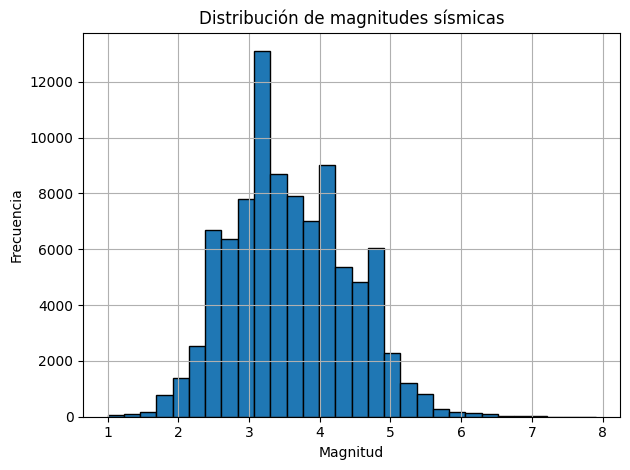

In [6]:

# ==============================================
# HISTOGRAMA DE MAGNITUDES
# ==============================================
# Para graficar usamos matplotlib, que trabaja con Pandas. Por eso traemos
# la Serie de magnitudes a memoria con compute() y dibujamos el histograma.
# ----------------------------------------------

# 1) Serie de magnitudes en Pandas
mags = df[MAG_COL].dropna().compute()

# 2) Histograma
plt.figure()
plt.hist(mags, bins=30, edgecolor="black")  # No fijamos colores para seguir la guía del profe
plt.title("Distribución de magnitudes sísmicas")
plt.xlabel("Magnitud")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


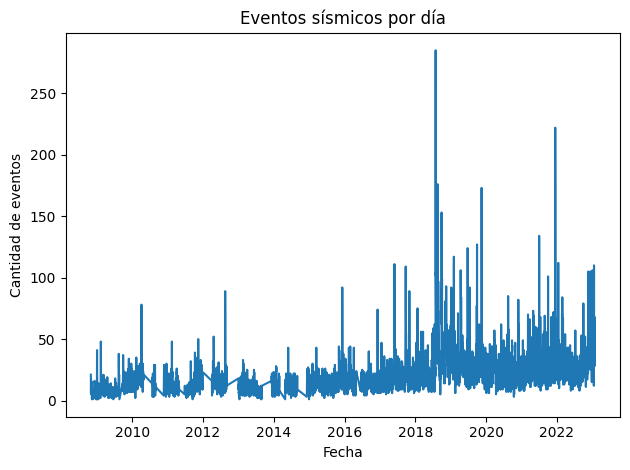

In [7]:

# ==============================================
# SERIE TEMPORAL: EVENTOS POR DÍA
# ==============================================
# Aquí construimos la serie diaria (conteos por día).
# Usamos floor('D') para truncar a día, agrupamos y computamos.
# ----------------------------------------------

daily = (
    df[[TIME_COL]]
    .assign(day=df[TIME_COL].dt.floor("D"))
    .groupby("day")
    .size()
    .compute()
    .sort_index()
)

# Gráfico de la serie diaria
plt.figure()
plt.plot(daily.index, daily.values)
plt.title("Eventos sísmicos por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.tight_layout()
plt.show()


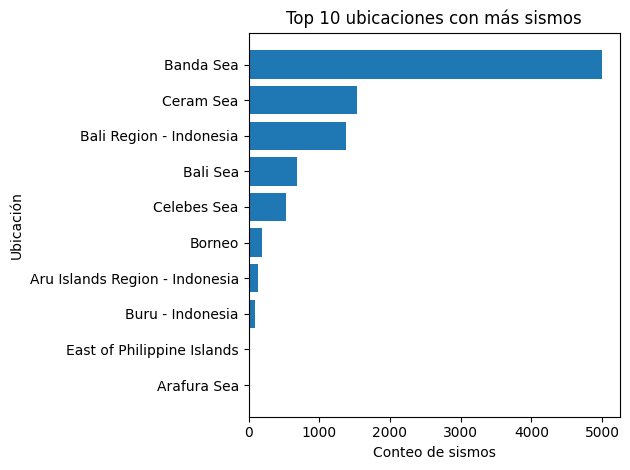

In [8]:

# ==============================================
# GRÁFICO: TOP 10 UBICACIONES
# ==============================================
# Graficamos el top de 'remark' que ya calculamos antes (top_places).
# ----------------------------------------------

if len(top_places) > 0:
    top10 = top_places.sort_values(ascending=True)  # barras horizontales de menor a mayor
    plt.figure()
    plt.barh(top10.index.astype(str), top10.values)
    plt.title("Top 10 ubicaciones con más sismos")
    plt.xlabel("Conteo de sismos")
    plt.ylabel("Ubicación")
    plt.tight_layout()
    plt.show()
else:
    print("No hay ubicaciones disponibles para graficar (top_places vacío).")


In [9]:

# ==============================================
# COMPARATIVA DE RENDIMIENTO: PANDAS VS DASK (EVENTOS POR DÍA)
# ==============================================
# Replicamos el cálculo de la serie diaria con Pandas y lo comparamos con Dask.
# Medimos tiempos con perf_counter y verificamos que los totales coinciden.
# ----------------------------------------------

# 1) Pandas
tp0 = perf_counter()
pdf = pd.read_csv("katalog_gempa.csv")  # usamos la misma ruta relativa
# Construimos 'time' de la misma forma que en Dask
pdf["time_str"] = pdf["tgl"].astype(str).str.strip() + " " + pdf["ot"].astype(str).str.strip()
pdf[TIME_COL] = pd.to_datetime(pdf["time_str"], errors="coerce")
# Limpiamos igual que en Dask
pdf = pdf.dropna(subset=[TIME_COL, MAG_COL])
# Serie diaria en Pandas
pandas_daily = pdf[TIME_COL].dt.floor("D").value_counts().sort_index()
tp1 = perf_counter()

# 2) Dask (ya tenemos 'daily' arriba). Lo referenciamos directamente.
td0 = perf_counter()
dask_daily = daily  # ya computado
td1 = perf_counter()

# 3) Reportamos tiempos y consistencia
print(f"Pandas tiempo: {tp1 - tp0:.2f} s | Filas: {len(pdf):,}")
print(f"Dask   tiempo: {td1 - td0:.2f} s | Particiones: {df.npartitions}")
print(f"Total eventos (Pandas vs Dask): {int(pandas_daily.sum())} vs {int(dask_daily.sum())}")


Pandas tiempo: 0.37 s | Filas: 92,887
Dask   tiempo: 0.00 s | Particiones: 1
Total eventos (Pandas vs Dask): 92887 vs 92887


In [10]:

# ==============================================
# GUARDAR RESULTADOS Y FIGURAS
# ==============================================
# Persistimos algunas salidas para el informe:
# - CSV con descriptivos de magnitud
# - CSV con eventos por día (Dask)
# - PNG con histograma de magnitudes
# ----------------------------------------------

# 1) Aseguramos carpetas
os.makedirs("results", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# 2) Guardamos descriptivos y serie diaria
desc.to_csv("results/descriptivos_magnitud.csv")
daily.to_frame(name="count").to_csv("results/eventos_por_dia_dask.csv")

# 3) Guardamos el histograma (re-render simple)
plt.figure()
plt.hist(mags, bins=30, edgecolor="black")
plt.title("Distribución de magnitudes sísmicas")
plt.xlabel("Magnitud")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("figures/hist_magnitudes.png", dpi=150)
plt.close()

print("Artefactos guardados en ./results y ./figures")


Artefactos guardados en ./results y ./figures


In [4]:
import dask.dataframe as dd

CSV_PATH = "katalog_gempa.csv"  # ajusta si es otra ruta
df = dd.read_csv(
    CSV_PATH,
    dtype={
        "tgl": "object",
        "ot": "object",
        "lat": "float64",
        "lon": "float64",
        "depth": "float64",
        "mag": "float64",
        "remark": "object"
    },
    assume_missing=True,
    blocksize="64MB"
)

# Si tienes columnas de fecha/hora:
df['time_str'] = df['tgl'].astype('string').str.strip() + " " + df['ot'].astype('string').str.strip()
df['time'] = dd.to_datetime(df['time_str'], errors='coerce')


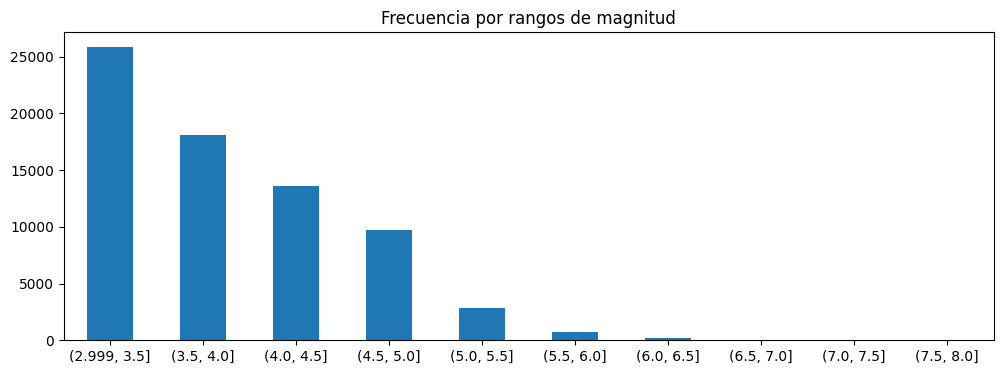

In [5]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.arange(3.0, 8.1, 0.5)
freq = df['mag'].map_partitions(lambda s: s.dropna().value_counts(bins=bins)).compute().sort_index()
freq.plot(kind='bar', figsize=(12,4), title="Frecuencia por rangos de magnitud")
plt.xticks(rotation=0)
plt.show()


In [6]:
stats_lugar = df.groupby('remark').agg({
    'mag': ['count','mean','max']
}).compute()
stats_lugar.columns = ['count','mag_mean','mag_max']
stats_lugar.query('count >= 50').sort_values('mag_max', ascending=False).head(10)


,count,mag_mean,mag_max
remark,,,
Irian Jaya Region - Indonesia,3137,3.937169,7.9
Southwest of Sumatra - Indonesia,1037,4.253713,7.7
Southern Sumatra - Indonesia,5314,3.709164,7.7
Northern Sumatra - Indonesia,5941,3.450614,7.7
Minahassa Peninsula - Sulawesi,9433,3.294699,7.5
Tanimbar Islands Reg. - Indonesia,329,4.698480,7.5
Flores Sea,1879,3.461096,7.3
Banda Sea,5003,4.396842,7.3
Celebes Sea,525,4.336952,7.2


Text(0, 0.5, 'Lat')

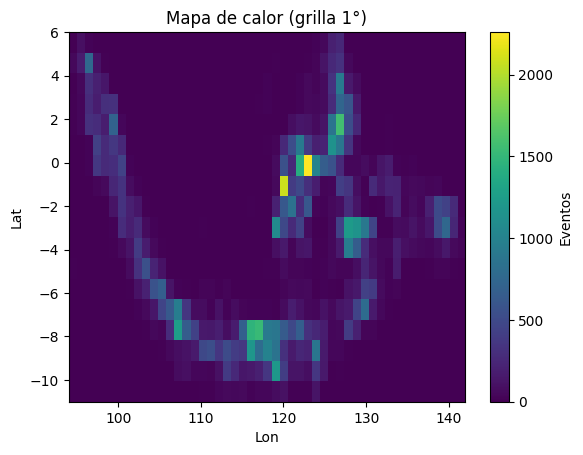

In [7]:
# Discretizar lat/lon en celdas de 1°
df['lat_bin'] = (df['lat'].round(0)).astype('float')
df['lon_bin'] = (df['lon'].round(0)).astype('float')
heat = df.groupby(['lat_bin','lon_bin']).size().compute().reset_index(name='count')
pivot = heat.pivot(index='lat_bin', columns='lon_bin', values='count').fillna(0)
plt.imshow(pivot.values, aspect='auto', origin='lower',
           extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()])
plt.colorbar(label="Eventos"); plt.title("Mapa de calor (grilla 1°)"); plt.xlabel("Lon"); plt.ylabel("Lat")


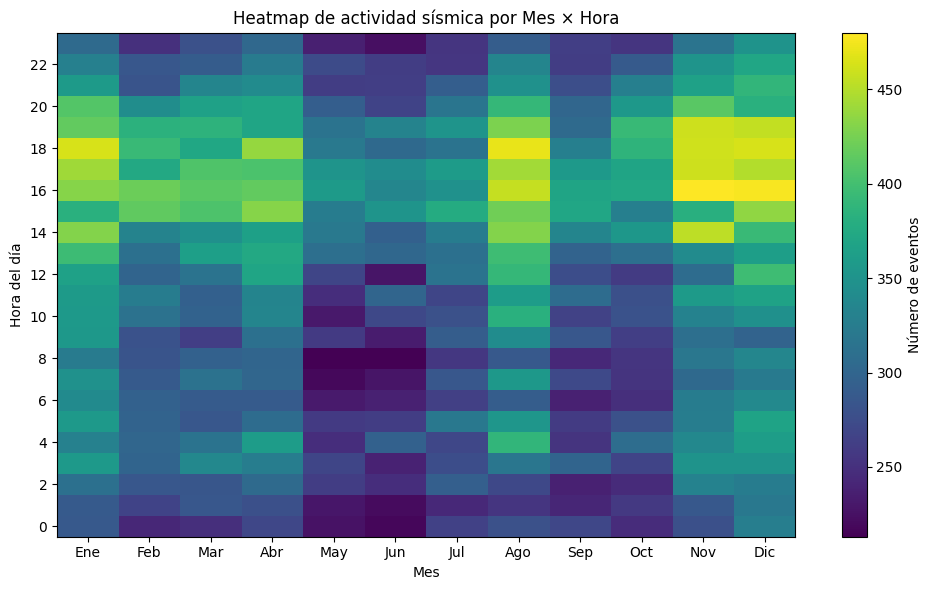

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que 'time' existe y es datetime
# df['time'] = dd.to_datetime(df['time'], errors='coerce')  # si no lo hiciste antes

# Extraer mes (1–12) y hora (0–23) sin traer todo a memoria
df['mes'] = df['time'].dt.month
df['hora'] = df['time'].dt.hour

# Conteo por mes x hora en Dask → compute al final
tabla = df.groupby(['mes','hora']).size().compute().rename('count').reset_index()

# Pasar a matriz para heatmap
pivot = tabla.pivot(index='hora', columns='mes', values='count').fillna(0)

plt.figure(figsize=(10,6))
plt.imshow(pivot.values, aspect='auto', origin='lower')
plt.colorbar(label='Número de eventos')
plt.yticks(range(0,24,2), range(0,24,2))
plt.xticks(range(12), ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], rotation=0)
plt.title('Heatmap de actividad sísmica por Mes × Hora')
plt.xlabel('Mes')
plt.ylabel('Hora del día')
plt.tight_layout()
plt.show()


C:\Users\ignac\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\dask_expr\_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


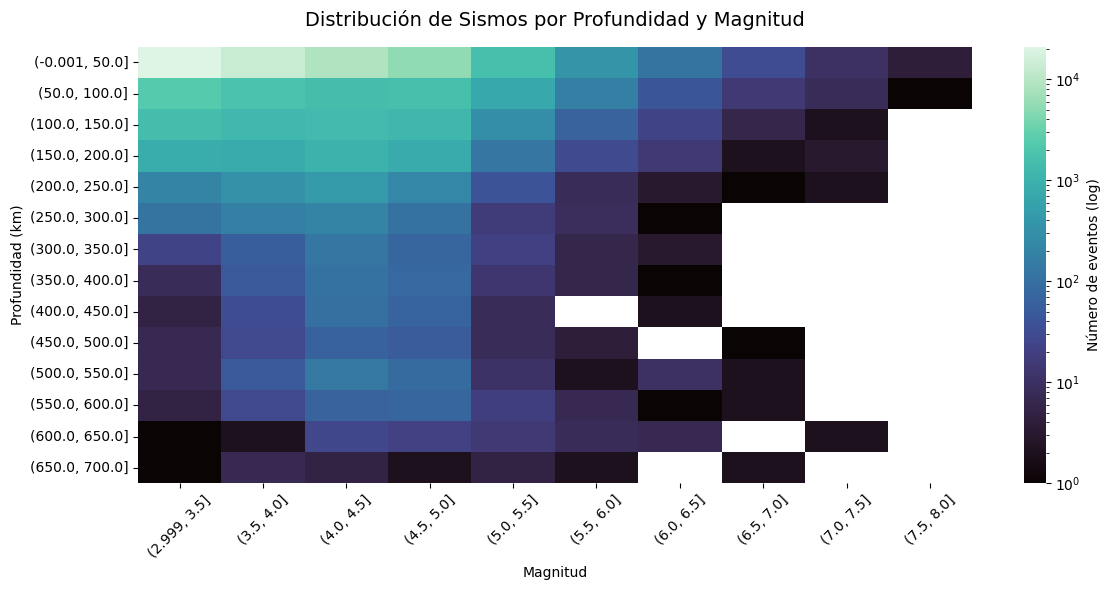

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bins más realistas y ajustados a tus datos
bins_depth = np.arange(0, 700+1, 50)   # cada 50 km
bins_mag   = np.arange(3.0, 8.1, 0.5)  # cada 0.5 magnitud

# Discretizar con pandas.cut en cada partición
def bin_cols(pdf):
    pdf = pdf.copy()
    pdf['depth_bin'] = pd.cut(pdf['depth'], bins=bins_depth, include_lowest=True)
    pdf['mag_bin']   = pd.cut(pdf['mag'],   bins=bins_mag,   include_lowest=True)
    return pdf[['depth_bin','mag_bin']]

binned = df.map_partitions(bin_cols)

# Contar ocurrencias
counts = binned.groupby(['depth_bin','mag_bin']).size().compute().rename('count').reset_index()

# Pivot para heatmap
pivot = counts.pivot(index='depth_bin', columns='mag_bin', values='count').fillna(0)

# Usar escala logarítmica para que se vean mejor los contrastes
plt.figure(figsize=(12,6))
sns.heatmap(
    pivot,
    cmap='mako',  # o 'YlOrRd', 'viridis'
    norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=pivot.max().max()),  # escala log
    cbar_kws={'label': 'Número de eventos (log)'}
)

plt.title('Distribución de Sismos por Profundidad y Magnitud', fontsize=14, pad=15)
plt.xlabel('Magnitud')
plt.ylabel('Profundidad (km)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
